In [1]:
#import standard libraries

import numpy as np
import matplotlib.pyplot as plt
import tidynamics as td
from scipy.optimize import curve_fit
from scipy.integrate import cumtrapz

import matplotlib
matplotlib.rcParams['xtick.labelsize']=20
matplotlib.rcParams['ytick.labelsize']=20
matplotlib.rcParams['font.size']=15
matplotlib.rcParams['legend.fontsize']=15
matplotlib.rcParams['axes.labelsize']=15
matplotlib.rcParams['text.latex.preamble']=[r'\usepackage{bm}', r'\usepackage{textgreek}', r'\usepackage{sfmath}', r'\usepackage{siunitx}', r'\sisetup{per-mode=reciprocal}    ', r'\DeclareSIUnit\Molar{M}']
matplotlib.rc('text',usetex=True)

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  from ipykernel import kernelapp as app


In [2]:
job_name = '50507548'                          # '50507546', '50507547', '50507548'
data_dir = '/Volumes/_work/genius/scratch/'

In [3]:
def exp_fit(t, p0, p1):
    return p0 * (1-np.exp(-p1*t))

6.0 25.0


/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


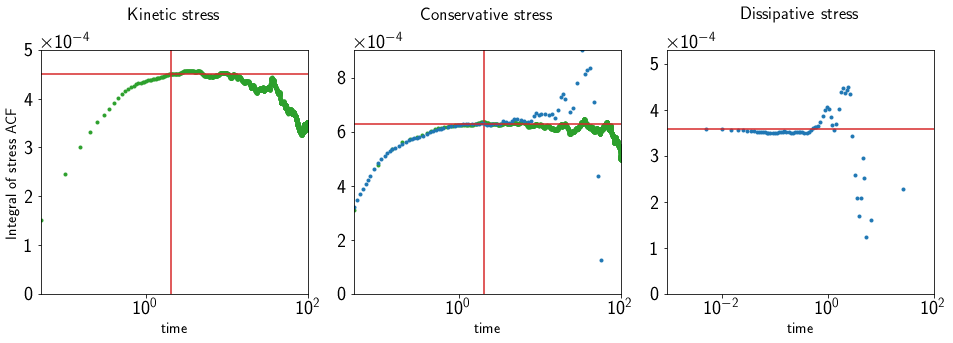

In [14]:
time = np.arange(0.0, 500000*0.005*10, 10*0.005)
samples = np.arange(len(time), 0, -1)
cutoff = 5000
limit = 2.0

plt.figure(figsize=(4*3.375, 1.5*3.375))

# Here we are plotting the figure that's shown in the paper
for i in [8]:
    j = i+1
    
    with open('../parameter_files/params_dpd.csv') as f:
        line = f.readlines()[j]
        line = line.split(',')
        
    rho, a_ij = float(line[0]), float(line[1])
    print(rho,a_ij)
    
    l = (10000/rho) ** (1/3)
    vol = 10000/rho
    eta_theo = 2*np.pi*4.5*rho**2/1575
    
    #Here we do the calculation by hand using tidynamics
    
    kin_stress = -1.0 * np.genfromtxt(
        data_dir + 'dpd_visc_' + job_name + '[' + str(j) +']/kin_stress.txt')
    
    old_stress = -1.0 * np.genfromtxt(
        data_dir + 'dpd_visc_' + job_name + '[' + str(j) +']/old_stress.txt')
    
    dpd_stress = -1.0 * np.genfromtxt(
        data_dir + 'dpd_visc_' + job_name + '[' + str(j) +']/dpd_stress.txt')
    
    kin_stress_acf = td.acf(kin_stress)
    old_stress_acf = td.acf(old_stress)
    dpd_stress_acf = td.acf(dpd_stress)
    
    kin_stress_int = cumtrapz(kin_stress_acf, x = time, initial = 0)
    old_stress_int = cumtrapz(old_stress_acf, x = time, initial = 0)
    dpd_stress_int = cumtrapz(dpd_stress_acf, x = time, initial = 0)
    
    temp = old_stress_int
    
    kin_visc, pcov = curve_fit(exp_fit, time[:cutoff], kin_stress_int[:cutoff], sigma=1/np.sqrt(samples[:cutoff]))
    old_visc, pcov = curve_fit(exp_fit, time[:cutoff], old_stress_int[:cutoff], sigma=1/np.sqrt(samples[:cutoff]))
    dpd_visc, pcov = curve_fit(exp_fit, time[:cutoff], dpd_stress_int[:cutoff], sigma=1/np.sqrt(samples[:cutoff]))
    
    ax1 = plt.subplot(131, rasterized=True)
    ax1.set_title('Kinetic stress', x=0.5, y=1.1)
    ax1.semilogx(time, kin_stress_int, 'o', markersize='3', color='tab:green', label = 'ACF tidynamics')
    #ax1.semilogx(time, exp_fit(time, *kin_visc), '--', color='tab:green', label = 'Fit to ACF tidynamics')
    ax1.axvline(limit, color='tab:red')
    ax1.set_xlim(time[1], 1e2)
    ax1.set_ylim(0, 1.5*kin_visc[0])
    #ax1.legend(loc='upper left')
    ax1.set_xlabel('time')
    ax1.set_ylabel('Integral of stress ACF')
    ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
    idx = np.searchsorted(time, limit)
    ax1.axhline(kin_stress_int[idx], color='tab:red')
    
    ax2 = plt.subplot(132, rasterized=True)
    ax2.set_title('Conservative stress', x=0.5, y=1.1)
    ax2.semilogx(time, old_stress_int, 'o', markersize='3', color='tab:green', label = 'ACF tidynamics')
    ax2.axvline(limit, color='tab:red')
    ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax2.set_xlim(time[1], 1e2)
    ax2.set_xlabel('time')
    
    ax3 = plt.subplot(133, rasterized=True)
    ax3.set_title('Dissipative stress', x=0.5, y=1.1)
    ax3.semilogx(time, dpd_stress_int, 'o', markersize='3', color='tab:green', label = 'ACF tidynamics', rasterized=True)
    ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax3.set_xlim(0.9e-3, 1e2)
    ax3.set_xlabel('time')
    
    # Here we use the correlated data from the Espresso correlator
    # The kinetic component can't be extracted here
    
    old_stress = np.load(
        data_dir + 'dpd_visc_' + job_name + '[' + str(j) +']/dpd_sample_old_stress_acf.npy')
    
    old_stress_avg = (old_stress[:,3] + old_stress[:,4] + old_stress[:,7]) / 3.
    
    old_stress_int = cumtrapz(old_stress_avg, x = old_stress[:,0], initial = 0)
    old_visc, pcov = curve_fit(exp_fit, old_stress[:100,0], old_stress_int[:100], sigma=1/np.sqrt(old_stress[:100,1]))
    
    dpd_stress = np.load(
        data_dir + 'dpd_visc_' + job_name + '[' + str(j) +']/dpd_sample_dpd_stress_acf.npy')
    
    dpd_stress_avg = (dpd_stress[:,3] + dpd_stress[:,4] + dpd_stress[:,7]) / 3.
    
    dpd_stress_int = cumtrapz(dpd_stress_avg, x = dpd_stress[:,0], initial = 0)
    dpd_visc, pcov = curve_fit(exp_fit, dpd_stress[:65,0], dpd_stress_int[:65], sigma=1/np.sqrt(dpd_stress[:65,1]))
    
    ax2 = plt.subplot(132, rasterized=True)
    ax2.semilogx(old_stress[:,0], old_stress_int, 'o', markersize='3', color='tab:blue', label = 'ACF ESPResSo', rasterized=True)
    ax2.set_ylim(0, 1.5*old_visc[0])
    
    idx = np.searchsorted(old_stress[:,0], limit)
    ax2.axhline(old_stress_int[idx], color='tab:red')
    
    ax3 = plt.subplot(133, rasterized=True)
    ax3.semilogx(dpd_stress[:,0], dpd_stress_int, 'o', markersize='3', color='tab:blue', label = 'ACF ESPResSo', rasterized=True)
    ax3.set_ylim(0, 1.5*dpd_visc[0])
    
    dpd_idx = 1
    ax3.axhline(dpd_stress_int[dpd_idx], color='tab:red')
    
plt.tight_layout()
#plt.savefig("acf_convergence.pdf")